<a href="https://colab.research.google.com/github/vincenzomanzoni/pytorch-forecasting-examples/blob/main/03_Pytorch_Forecasting_Example_NBeats_with_Hyperparameters_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Forecasting | N-Beats with Hyperparameters tuning


## Install Pytorch Forecasting and import libraries

In [41]:
!pip install pytorch-forecasting optuna > /dev/null

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_contour
from optuna.visualization import plot_param_importances

import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from pytorch_forecasting import TimeSeriesDataSet, Baseline, NBeats
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

## Dataset generation

In [43]:
data = generate_ar_data(seasonality=12, timesteps=364, n_series=1, seed=42, trend = 3.0, noise = 0.2)

In [44]:
data.head()

,series,time_idx,value
0,0,0,0.000000
1,0,1,0.199311
2,0,2,0.538868
3,0,3,0.683969
4,0,4,0.681237


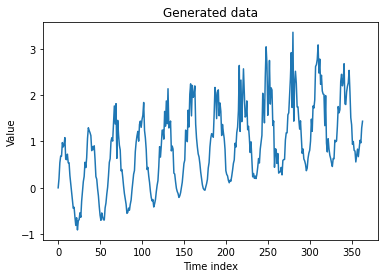

In [45]:
plt.plot(data.time_idx, data.value)
plt.title('Generated data')
plt.xlabel('Time index')
plt.ylabel('Value')
plt.show()

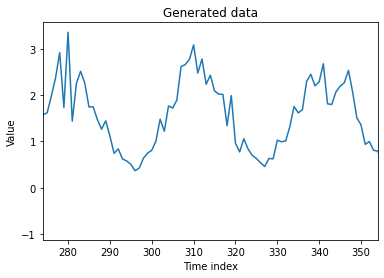

In [46]:
plt.plot(data.value)
plt.xlim(354-80, 354)
plt.title('Generated data')
plt.xlabel('Time index')
plt.ylabel('Value')
plt.show()

## Creation of datasets and dataloaders

In [84]:
# Create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20
batch_size = 32

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    group_ids=["series"],
    time_varying_unknown_reals=["value"],    
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,    
)
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

## Calculate Baseline Error

In [85]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.5114)

## Train NBeats

In [102]:
pl.seed_everything(42)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

import logging 
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

def objective(trial):
  trainer = pl.Trainer(      
      max_epochs=100,
      gpus=1,
      weights_summary="top",
      gradient_clip_val=trial.suggest_float("gradient_clip_val", 0.01, 0.1, log=True),
      callbacks=[early_stop_callback],
      limit_train_batches=30,#trial.suggest_int("limit_train_batches", 10, 30),
      progress_bar_refresh_rate=0,
  )

  net = NBeats.from_dataset(
    training,
    learning_rate=trial.suggest_float("learning_rate", 0.01, 1, log=True),
    weight_decay=trial.suggest_float("weight_decay", 1e-3, 1e-1, log=True),
    widths=[512], #[32, 512]
    backcast_loss_ratio=trial.suggest_float("backcast_loss_ratio", 0.1, 1, log=True),
    stack_types=['generic'],
    num_blocks=[1],
    log_interval = 10
  )

  trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
  )

  best_model_path = trainer.checkpoint_callback.best_model_path  
  best_model = NBeats.load_from_checkpoint(best_model_path)  

  actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
  predictions = best_model.predict(val_dataloader)
  mae = (actuals - predictions).abs().mean().item()
  mape = (100 * (actuals - predictions) / actuals).abs().mean().item()

  trial.set_user_attr("best_model_path", best_model_path)
  trial.set_user_attr("mae", mae)
  trial.set_user_attr("mape", mape)

  return mae

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10, timeout=300, show_progress_bar=True)

In [104]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

In [105]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  0
  Number of complete trials:  10


In [106]:
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)

Best trial:
  Value:  0.13900074362754822


In [107]:
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))
print()

print("  User attrs: ")
for key, value in trial.user_attrs.items():
  print("    {}: {}".format(key, value))

best_model_path = trial.user_attrs["best_model_path"]

  Params: 
    gradient_clip_val: 0.020117771939236008
    learning_rate: 0.07474783949319688
    weight_decay: 0.006155161685847547
    backcast_loss_ratio: 0.11462614762543354

  User attrs: 
    best_model_path: /content/lightning_logs/version_213/checkpoints/epoch=48-step=391.ckpt
    mae: 0.13900074362754822
    mape: 10.776137351989746


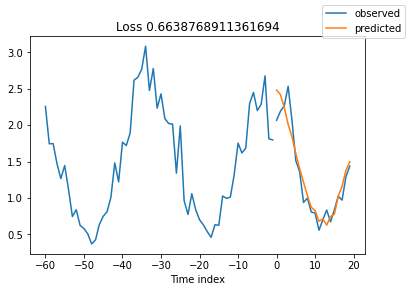

In [108]:
best_model = NBeats.load_from_checkpoint(best_model_path)  
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)
best_model.plot_prediction(x, raw_predictions, add_loss_to_title=True);

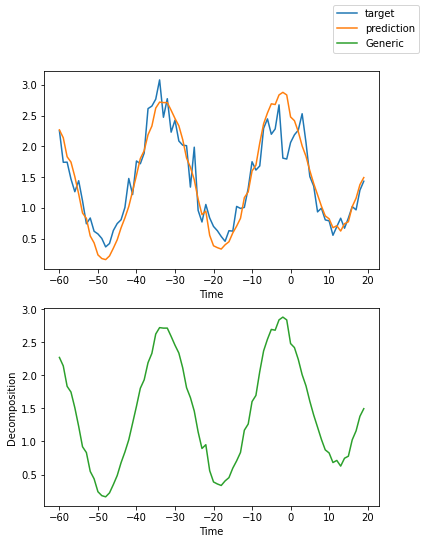

In [109]:
best_model.plot_interpretation(x, raw_predictions, idx=0);

In [111]:
plot_optimization_history(study)

In [ ]:
plot_parallel_coordinate(study)

In [112]:
plot_contour(study)

In [110]:
plot_contour(study, params=["gradient_clip_val", "learning_rate"])

In [113]:
plot_param_importances(study)